In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import os.path
#import pyomo
import pyomo.environ as pyo
#import pvlib
#import math
#from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
import time
from pyomo.environ import *
import sys,os
sys.path.append(os.getcwd())
import random
import os
from datetime import datetime
import logging
import traceback
from shutil import copyfile
import multiprocessing
#import cloudpickle
from pyomo.common.tempfiles import TempfileManager

## 2. Исходные данные

### 2.1 Задаем нагрузку, мощность PV и Параметры ДГУ, СЭС и СНЭ

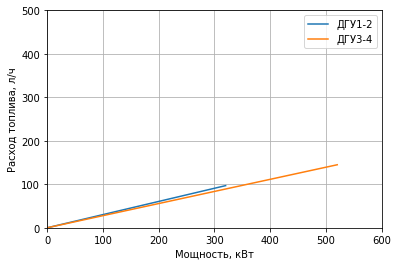

In [11]:
class reading:

    Load=[0,0,0,0,0]
    PV=[0,0,0,0,0,0,0]

    output = []

    N = 4
    N = np.array([n for n in range(0, N)])
    T = np.array([t for t in range(0, 5)])
    T1 = 0
    T2 = 5

    p12 = np.arange(0, 321)
    p34 = np.arange(0, 521)
    p_PV = np.arange(0, 137)
    p_BESS = np.arange(0, 151)


    DGU1_pmax = 320 #кВт
    DGU1_pmin = 0.5*DGU1_pmax

    DGU2_pmax = 320 #кВт
    DGU2_pmin = 0.5*DGU2_pmax

    DGU3_pmax = 520 #кВт
    DGU3_pmin = 0.5*DGU3_pmax

    DGU4_pmax = 520 #кВт
    DGU4_pmin = 0.5*DGU4_pmax

    DGU1_fuel =  0.3031*p12
    DGU2_fuel =  0.3031*p12
    DGU3_fuel = 0.2788*p34
    DGU4_fuel = 0.2788*p34

    d1_min_up_time = 3
    d2_min_up_time = 3
    d3_min_up_time = 3
    d4_min_up_time = 3

    d1_min_down_time = 3
    d2_min_down_time = 3
    d3_min_down_time = 3
    d4_min_down_time = 3

    d12_startup_cost = 1000
    d34_startup_cost = 2000

    d12_shutdown_cost = 1100
    d34_shutdown_cost = 2100

    Fuel_price = 70 #цена за литр диз.топлива 
    #коэффициенты из расходных характеристик ДГУ
    DGU12_a = 0.0219
    DGU12_b = 0.3125
    DGU34_a = 0.049
    DGU34_b = 0.2788

    ESS_inv = 150

    bat1_dod = 50
    bat2_dod = 50

    soc1_after = 100
    soc2_after = 100

    PV_inv_Pmax = 136

    fig, ax = plt.subplots(1,1)

    ax.plot(DGU1_fuel, label='ДГУ1-2')
    ax.plot(DGU3_fuel, label='ДГУ3-4')

    ax.set_xlim(0, 600)
    ax.set_ylim(0, 500)
    ax.set_xlabel('Мощность, кВт')
    ax.set_ylabel('Расход топлива, л/ч')
    ax.legend(loc='best')
    ax.grid()


### 2.3 Формулировка задачи оптимизации в Pyomo

In [12]:
class opt_pyomo_formulating:

    
    m = pyo.ConcreteModel()
    m.N = pyo.Set(initialize=reading.N)
    m.T = pyo.Set(initialize=reading.T)


    #Ограничения
    def balance(self, model, i):
        return self.m.x1[i] + self.m.x2[i] + self.m.x3[i] + self.m.x4[i] + self.m.bat1_dch[i] - self.m.bat1_ch[i] + self.m.bat2_dch[i] - self.m.bat2_ch[i] + self.m.PV1[i] + self.m.PV2[i] + self.m.PV3[i] + self.m.PV4[i] + self.m.PV5[i] + self.m.PV6[i] + self.m.PV7[i] == (np.asarray(reading.init_data_import()[0])[i]) 

    def d1_start_up_cost(self, model, i):
        if i == reading.T1:
            return self.m.suc1[i] >= reading.d12_startup_cost*(self.m.u1[i]-reading.init_data_import()[4])
        else:
            return self.m.suc1[i] >= reading.d12_startup_cost*(self.m.u1[i]-self.m.u1[i-1])
        
    def d2_start_up_cost(self, model, i):
        if i == reading.T1:
            return self.m.suc2[i] >= reading.d12_startup_cost*(self.m.u2[i]-reading.init_data_import()[8])
        else:
            return self.m.suc2[i] >= reading.d12_startup_cost*(self.m.u2[i]-self.m.u2[i-1])
        
    def d3_start_up_cost(self, model, i):
        if i == reading.T1:
            return self.m.suc3[i] >= reading.d34_startup_cost*(self.m.u3[i]-reading.init_data_import()[12])
        else:
            return self.m.suc3[i] >= reading.d34_startup_cost*(self.m.u3[i]-self.m.u3[i-1])
        
    def d4_start_up_cost(self, model, i):
        if i == reading.T1:
            return self.m.suc4[i] >= reading.d34_startup_cost*(self.m.u4[i]-reading.init_data_import()[16])
        else:
            return self.m.suc4[i] >= reading.d34_startup_cost*(self.m.u4[i]-self.m.u4[i-1])
        
    def d1_shut_down_cost(self, model, i):
        if i == reading.T1:
            return self.m.sdc1[i] >= reading.d12_shutdown_cost*(reading.init_data_import()[4]-self.m.u1[i])
        else:
            return self.m.sdc1[i] >= reading.d12_shutdown_cost*(self.m.u1[i-1]-self.m.u1[i])

    def d2_shut_down_cost(self, model, i):
        if i == reading.T1:
            return self.m.sdc2[i] >= reading.d12_shutdown_cost*(reading.init_data_import()[8]-self.m.u2[i])
        else:
            return self.m.sdc2[i] >= reading.d12_shutdown_cost*(self.m.u2[i-1]-self.m.u2[i])
        
    def d3_shut_down_cost(self, model, i):
        if i == reading.T1:
            return self.m.sdc3[i] >= reading.d34_shutdown_cost*(reading.init_data_import()[12]-self.m.u3[i])
        else:
            return self.m.sdc3[i] >= reading.d34_shutdown_cost*(self.m.u3[i-1]-self.m.u3[i])

    def d4_shut_down_cost(self, model, i):
        if i == reading.T1:
            return self.m.sdc4[i] >= reading.d34_shutdown_cost*(reading.init_data_import()[16]-self.m.u4[i])
        else:
            return self.m.sdc4[i] >= reading.d34_shutdown_cost*(self.m.u4[i-1]-self.m.u4[i])


    # def d1o(model, i):
    #     if i == T1:
    #         return m.u1[i] - d1_min_up_time*(m.u1[i] - u1_start) >= 0
    #     else:

    #         return sum(uj) >= d1_min_up_time*(m.u1[i] - m.u1[i-1])


    # def d2o(model, i):
    #     if i == T1:
    #         return (1-m.u3[i]) >= d3_min_down_time*(u3_start - m.u3[i])
    #     if i > T2-3:
    #         return m.u3[i+1] + m.u3[i+2] + m.u3[i+3]  >= d1_min_down_time*(m.u1[i-1] - m.u1[i])

    # def d1_partial(model, i):
    #     return m.x1

    def d1_min_up_time_c(self, model, i):
        if i == reading.T1:
            return (reading.init_data_import()[5] - reading.d1_min_up_time)*(reading.init_data_import()[4] - self.m.u1[i]) >= 0
        elif i <= reading.T1+2:
            uj = []
            uj.append(self.m.u1[i-1])
            for j in range(reading.T1, i):
                uj.append(self.m.u1[j])
            return ((sum(uj) - reading.d1_min_up_time)*(self.m.u1[i-1] - self.m.u1[i])) >= 0
        else:
            return ((self.m.u1[i-1] + self.m.u1[i-2] + self.m.u1[i-3] - reading.d1_min_up_time)*(self.m.u1[i-1] - self.m.u1[i])) >= 0
        
    def d2_min_up_time_c(self, model, i):
        if i == reading.T1:
            return (reading.init_data_import()[9] - reading.d2_min_up_time)*(reading.init_data_import()[8] - self.m.u2[i]) >= 0
        elif i <= reading.T1+2:
            uj = []
            uj.append(self.m.u2[i-1])
            for j in range(reading.T1, i):
                uj.append(self.m.u2[j])
            return ((sum(uj) - reading.d2_min_up_time)*(self.m.u2[i-1] - self.m.u2[i])) >= 0
        else:
            return ((self.m.u2[i-1] + self.m.u2[i-2] + self.m.u2[i-3] - reading.d2_min_up_time)*(self.m.u2[i-1] - self.m.u2[i])) >= 0
        
    def d3_min_up_time_c(self, model, i):
        if i == reading.T1:
            return (reading.init_data_import()[13] - reading.d3_min_up_time)*(reading.init_data_import()[12] - self.m.u3[i]) >= 0
        elif i <= reading.T1+2:
            uj = []
            uj.append(self.m.u3[i-1])
            for j in range(reading.T1, i):
                uj.append(self.m.u3[j])
            return ((sum(uj) - reading.d3_min_up_time)*(self.m.u3[i-1] - self.m.u3[i])) >= 0
        else:
            return ((self.m.u3[i-1] + self.m.u3[i-2] + self.m.u3[i-3] - reading.d3_min_up_time)*(self.m.u3[i-1] - self.m.u3[i])) >= 0

    def d4_min_up_time_c(self, model, i):
        if i == reading.T1:
            return (reading.init_data_import()[17] - reading.d4_min_up_time)*(reading.init_data_import()[16] - self.m.u4[i]) >= 0
        elif i <= reading.T1+2:
            uj = []
            uj.append(self.m.u4[i-1])
            for j in range(reading.T1, i):
                uj.append(self.m.u4[j])
            return ((sum(uj) - reading.d4_min_up_time)*(self.m.u4[i-1] - self.m.u4[i])) >= 0
        else:
            return ((self.m.u4[i-1] + self.m.u4[i-2] + self.m.u4[i-3] - reading.d4_min_up_time)*(self.m.u4[i-1] - self.m.u4[i])) >= 0

    def d1_min_down_time_c(self, model, i):
        if i == reading.T1:
            return (reading.init_data_import()[6] + reading.d1_min_down_time)*(-reading.init_data_import()[4] + self.m.u1[i]) <= 0
        elif i <= reading.T1+2:
            uj = []
            uj.append(self.m.u1[i-1])
            for j in range(reading.T1, i):
                uj.append(self.m.u1[j])
            return ((sum(uj) - 2 + reading.d1_min_down_time)*(-self.m.u1[i-1] + self.m.u1[i])) <= 0
        else:
            return ((self.m.u1[i-1] + self.m.u1[i-2] + self.m.u1[i-3] - 3 + reading.d1_min_down_time)*(-self.m.u1[i-1] + self.m.u1[i])) <= 0

    def d2_min_down_time_c(self, model, i):
        if i == reading.T1:
            return (reading.init_data_import()[10] + reading.d2_min_down_time)*(-reading.init_data_import()[8] + self.m.u2[i]) <= 0
        elif i <= reading.T1+2:
            uj = []
            uj.append(self.m.u2[i-1])
            for j in range(reading.T1, i):
                uj.append(self.m.u2[j])
            return ((sum(uj) - 2 + reading.d2_min_down_time)*(-self.m.u2[i-1] + self.m.u2[i])) <= 0
        else:
            return ((self.m.u2[i-1] + self.m.u2[i-2] + self.m.u2[i-3] - 3 + reading.d2_min_down_time)*(-self.m.u2[i-1] + self.m.u2[i])) <= 0

    def d3_min_down_time_c(self, model, i):
        if i == reading.T1:
            return (reading.init_data_import()[14] + reading.d3_min_down_time)*(-reading.init_data_import()[12] + self.m.u3[i]) <= 0
        elif i <= reading.T1+2:
            uj = []
            uj.append(self.m.u3[i-1])
            for j in range(reading.T1, i):
                uj.append(self.m.u3[j])
            return ((sum(uj) - 2 + reading.d3_min_down_time)*(-self.m.u3[i-1] + self.m.u3[i])) <= 0
        else:
            return ((self.m.u3[i-1] + self.m.u3[i-2] + self.m.u3[i-3] - 3 + reading.d3_min_down_time)*(-self.m.u3[i-1] + self.m.u3[i])) <= 0

    def d4_min_down_time_c(self, model, i):
        if i == reading.T1:
            return (reading.init_data_import()[18] + reading.d4_min_down_time)*(-reading.init_data_import()[16] + self.m.u4[i]) <= 0
        elif i <= reading.T1+2:
            uj = []
            uj.append(self.m.u4[i-1])
            for j in range(reading.T1, i):
                uj.append(self.m.u4[j])
            return ((sum(uj) - 2 + reading.d4_min_down_time)*(-self.m.u4[i-1] + self.m.u4[i])) <= 0
        else:
            return ((self.m.u4[i-1] + self.m.u4[i-2] + self.m.u4[i-3] - 3 + reading.d4_min_down_time)*(-self.m.u4[i-1] + self.m.u4[i])) <= 0

    #ограничение глубины разряда СНЭ  
    def soc1_ctrl(self, model, i):
        if i == reading.T1:
            return self.m.soc1[i] == reading.init_data_import()[22] - 100*self.m.bat1_dch[i]/700 + 100*self.m.bat1_ch[i]/700
        else:
            return self.m.soc1[i] == self.m.soc1[i-1] - 100*self.m.bat1_dch[i]/700 + 100*self.m.bat1_ch[i]/700

    def soc2_ctrl(self, model, i):
        if i == reading.T1:
            return self.m.soc2[i] == reading.init_data_import()[23] - 100*self.m.bat2_dch[i]/700 + 100*self.m.bat2_ch[i]/700
        else:
            return self.m.soc2[i] == self.m.soc2[i-1] - 100*self.m.bat2_dch[i]/700 + 100*self.m.bat2_ch[i]/700
        
    #СНЭ не должна заряжаться и разряжаться одновременно     
    def ch_x_dch1 (self, model, i):
        return self.m.bat1_ch[i] * self.m.bat1_dch[i] == 0

    def ch_x_dch2 (self, model, i):
        return self.m.bat2_ch[i] * self.m.bat2_dch[i] == 0

    def ess12(self, model, i):
        return self.m.bat1_dch[i] - self.m.bat2_ch[i] - self.m.bat1_dch[i] == 0 #m.bat1_dch[i] - m.bat2_ch[i] - m.bat1_dch[i] <= 0 

    def ess21(self, model, i):
        return self.m.bat2_dch[i] - self.m.bat1_ch[i] - self.m.bat2_dch[i] == 0 

    #если СНЭ заряжена не на 100%, не ограничиваем инверторы СЭС 
    def curtailment_control1 (self, model, i):
        return self.m.PV1[i]+ self.m.PV2[i]+self.m.PV3[i]+self.m.PV4[i]+self.m.PV5[i]+self.m.PV6[i]+self.m.PV7[i] - reading.init_data_import()[1][i] - self.m.bat1_ch[i]/reading.ESS_inv  <= 0 

    def curtailment_control2 (self, model, i):
        return self.m.PV1[i]+ self.m.PV2[i]+self.m.PV3[i]+self.m.PV4[i]+self.m.PV5[i]+self.m.PV6[i]+self.m.PV7[i] - reading.init_data_import()[1][i] - self.m.bat2_ch[i]/reading.ESS_inv  <= 0 

    def d1_availability (self, model, i):
        return self.m.u1[i] == self.m.u1[i] * reading.init_data_import()[7]

    def d2_availability (self, model, i):
        return self.m.u2[i] == self.m.u2[i] * reading.init_data_import()[11]

    def d3_availability (self, model, i):
        return self.m.u3[i] == self.m.u3[i] * reading.init_data_import()[15]

    def d4_availability (self, model, i):
        return self.m.u4[i] == self.m.u4[i] * reading.init_data_import()[19]


    def ess1_availability (self, model, i):
        return self.m.bat1_dch[i] + self.m.bat1_ch[i] == (self.m.bat1_dch[i] + self.m.bat1_ch[i]) * reading.init_data_import()[20]

    def ess2_availability (self, model, i):
        return self.m.bat2_dch[i] + self.m.bat2_ch[i] == (self.m.bat2_dch[i] + self.m.bat2_ch[i]) * reading.init_data_import()[21]

    def cycle1(self, model, i):
        return self.m.soc1[reading.T1+reading.T2-reading.T1-1] >= reading.soc1_after

    def cycle2(self, model, i):
        return self.m.soc2[reading.T1+reading.T2-reading.T1-1] >= reading.soc2_after

    def as_one1(self, model, i):
        return self.m.bat1_dch[i] == self.m.bat2_dch[i] 

    def as_one2(self, model, i):
        return self.m.bat1_ch[i] == self.m.bat2_ch[i] 

    def unit_commitment(self):
 

        self.m.x1 = pyo.Var(self.m.T, domain=pyo.NonNegativeReals, bounds = (0, reading.DGU1_pmax))
        self.m.u1 = pyo.Var(self.m.T, domain=pyo.Binary)
        
        self.m.x2 = pyo.Var(self.m.T, domain=pyo.NonNegativeReals, bounds = (0, reading.DGU2_pmax))
        self.m.u2 = pyo.Var(self.m.T, domain=pyo.Binary)
        
        self.m.x3 = pyo.Var(self.m.T, domain=pyo.NonNegativeReals, bounds = (0, reading.DGU3_pmax))
        self.m.u3 = pyo.Var(self.m.T, domain=pyo.Binary)
        
        self.m.x4 = pyo.Var(self.m.T, domain=pyo.NonNegativeReals, bounds = (0, reading.DGU4_pmax))
        self.m.u4 = pyo.Var(self.m.T, domain=pyo.Binary)
        
        self.m.bat1_dch = pyo.Var(self.m.T, domain=pyo.NonNegativeReals, bounds = (0, reading.ESS_inv))
        self.m.bat1_ch = pyo.Var(self.m.T, domain=pyo.NonNegativeReals, bounds = (0, reading.ESS_inv))
        
        self.m.bat2_dch = pyo.Var(self.m.T, domain=pyo.NonNegativeReals, bounds = (0, reading.ESS_inv))
        self.m.bat2_ch = pyo.Var(self.m.T, domain=pyo.NonNegativeReals, bounds = (0, reading.ESS_inv))
        
        self.m.soc1 = pyo.Var(self.m.T, domain=pyo.NonNegativeReals, bounds = (reading.bat1_dod, 100))
        self.m.soc2 = pyo.Var(self.m.T, domain=pyo.NonNegativeReals, bounds = (reading.bat2_dod, 100))
        
        self.m.suc1 = pyo.Var(self.m.T, domain=pyo.NonNegativeReals, bounds = (0, reading.d12_startup_cost))
        self.m.suc2 = pyo.Var(self.m.T, domain=pyo.NonNegativeReals, bounds = (0, reading.d12_startup_cost))
        self.m.suc3 = pyo.Var(self.m.T, domain=pyo.NonNegativeReals, bounds = (0, reading.d34_startup_cost))
        self.m.suc4 = pyo.Var(self.m.T, domain=pyo.NonNegativeReals, bounds = (0, reading.d34_startup_cost))
        
        self.m.sdc1 = pyo.Var(self.m.T, domain=pyo.NonNegativeReals, bounds = (0, reading.d12_shutdown_cost))
        self.m.sdc2 = pyo.Var(self.m.T, domain=pyo.NonNegativeReals, bounds = (0, reading.d12_shutdown_cost))
        self.m.sdc3 = pyo.Var(self.m.T, domain=pyo.NonNegativeReals, bounds = (0, reading.d34_shutdown_cost))
        self.m.sdc4 = pyo.Var(self.m.T, domain=pyo.NonNegativeReals, bounds = (0, reading.d34_shutdown_cost))
        
        self.m.PV1 = pyo.Var(self.m.T, domain=pyo.NonNegativeReals, bounds = (0, reading.PV_inv_Pmax))
        self.m.PV2 = pyo.Var(self.m.T, domain=pyo.NonNegativeReals, bounds = (0, reading.PV_inv_Pmax))
        self.m.PV3 = pyo.Var(self.m.T, domain=pyo.NonNegativeReals, bounds = (0, reading.PV_inv_Pmax))
        self.m.PV4 = pyo.Var(self.m.T, domain=pyo.NonNegativeReals, bounds = (0, reading.PV_inv_Pmax))
        self.m.PV5 = pyo.Var(self.m.T, domain=pyo.NonNegativeReals, bounds = (0, reading.PV_inv_Pmax))
        self.m.PV6 = pyo.Var(self.m.T, domain=pyo.NonNegativeReals, bounds = (0, reading.PV_inv_Pmax))
        self.m.PV7 = pyo.Var(self.m.T, domain=pyo.NonNegativeReals, bounds = (0, reading.PV_inv_Pmax))
        
        #m.PV1_s = pyo.Var(m.T, domain=pyo.Binary)
        #m.PV2_s = pyo.Var(m.T, domain=pyo.Binary)
        
        
        # целевая функция
        self.m.cost = pyo.Objective(expr = sum(reading.Fuel_price*((reading.DGU12_a*reading.DGU1_pmax*self.m.u1[t] + reading.DGU12_b*self.m.x1[t]) + (reading.DGU12_a*reading.DGU2_pmax*self.m.u2[t] + reading.DGU12_b*self.m.x2[t]) +
                                          (reading.DGU34_a*reading.DGU3_pmax*self.m.u3[t] + reading.DGU34_b*self.m.x3[t]) + (reading.DGU34_a*reading.DGU4_pmax*self.m.u4[t] + reading.DGU34_b*self.m.x4[t])) + self.m.suc1[t] +
                                          self.m.suc2[t] + self.m.suc3[t] + self.m.suc4[t] + self.m.sdc1[t] +
                                          self.m.sdc2[t] + self.m.sdc3[t] + self.m.sdc4[t] +
                                          27432*0.00000033*(self.m.bat1_ch[t]+self.m.bat1_dch[t]) + 27432*0.00000033*(self.m.bat2_ch[t]+self.m.bat2_dch[t]) + #пока здесь указаны левые цифры
                                          self.m.u1[t]*100 + self.m.u2[t]*100 + self.m.u3[t]*100 + self.m.u4[t]*100
                                          for t in self.m.T), sense=pyo.minimize)
        
        
        self.m.demand = pyo.Constraint(self.m.T, rule=self.balance)
             

        
        self.m.lb1 = pyo.Constraint(self.m.T, rule=lambda m, t: reading.DGU1_pmin*m.u1[t] <= m.x1[t])
        self.m.ub1 = pyo.Constraint(self.m.T, rule=lambda m, t: reading.DGU1_pmax*m.u1[t] >= m.x1[t])
        self.m.lb2 = pyo.Constraint(self.m.T, rule=lambda m, t: reading.DGU2_pmin*m.u2[t] <= m.x2[t])
        self.m.ub2 = pyo.Constraint(self.m.T, rule=lambda m, t: reading.DGU2_pmax*m.u2[t] >= m.x2[t])
        self.m.lb3 = pyo.Constraint(self.m.T, rule=lambda m, t: reading.DGU3_pmin*m.u3[t] <= m.x3[t])
        self.m.ub3 = pyo.Constraint(self.m.T, rule=lambda m, t: reading.DGU3_pmax*m.u3[t] >= m.x3[t])
        self.m.lb4 = pyo.Constraint(self.m.T, rule=lambda m, t: reading.DGU4_pmin*m.u4[t] <= m.x4[t])
        self.m.ub4 = pyo.Constraint(self.m.T, rule=lambda m, t: reading.DGU4_pmax*m.u4[t] >= m.x4[t])
        
        self.m.pv1 = pyo.Constraint(self.m.T, rule=lambda m, t: m.PV1[t] <= reading.PV[t]) #7 - число инверторов СЭС
        self.m.pv2 = pyo.Constraint(self.m.T, rule=lambda m, t: m.PV2[t] <= reading.PV[t])
        self.m.pv3 = pyo.Constraint(self.m.T, rule=lambda m, t: m.PV3[t] <= reading.PV[t])
        self.m.pv4 = pyo.Constraint(self.m.T, rule=lambda m, t: m.PV4[t] <= reading.PV[t])
        self.m.pv5 = pyo.Constraint(self.m.T, rule=lambda m, t: m.PV5[t] <= reading.PV[t])
        self.m.pv6 = pyo.Constraint(self.m.T, rule=lambda m, t: m.PV6[t] <= reading.PV[t])
        self.m.pv7 = pyo.Constraint(self.m.T, rule=lambda m, t: m.PV7[t] <= reading.PV[t])
        
        self.m.pv1_curtailment = pyo.Constraint(self.m.T, rule=self.curtailment_control1)
        self.m.pv2_curtailment = pyo.Constraint(self.m.T, rule=self.curtailment_control2)
        
        self.m.min_up_time_d1 = pyo.Constraint(self.m.T, rule=self.d1_min_up_time_c)
        self.m.min_up_time_d2 = pyo.Constraint(self.m.T, rule=self.d2_min_up_time_c)
        self.m.min_up_time_d3 = pyo.Constraint(self.m.T, rule=self.d3_min_up_time_c)
        self.m.min_up_time_d4 = pyo.Constraint(self.m.T, rule=self.d4_min_up_time_c)
        
        self.m.min_down_time_d1 = pyo.Constraint(self.m.T, rule=self.d1_min_down_time_c)
        self.m.min_down_time_d2 = pyo.Constraint(self.m.T, rule=self.d2_min_down_time_c)
        self.m.min_down_time_d3 = pyo.Constraint(self.m.T, rule=self.d3_min_down_time_c)
        self.m.min_down_time_d4 = pyo.Constraint(self.m.T, rule=self.d4_min_down_time_c)
        
        self.m.su1 = pyo.Constraint(self.m.T, rule=self.d1_start_up_cost)
        self.m.su2 = pyo.Constraint(self.m.T, rule=self.d2_start_up_cost)
        self.m.su3 = pyo.Constraint(self.m.T, rule=self.d3_start_up_cost)
        self.m.su4 = pyo.Constraint(self.m.T, rule=self.d4_start_up_cost)
        
        self.m.sd1 = pyo.Constraint(self.m.T, rule=self.d1_shut_down_cost)
        self.m.sd2 = pyo.Constraint(self.m.T, rule=self.d2_shut_down_cost)
        self.m.sd3 = pyo.Constraint(self.m.T, rule=self.d3_shut_down_cost)
        self.m.sd4 = pyo.Constraint(self.m.T, rule=self.d4_shut_down_cost)
        
        self.m.d1_ava = pyo.Constraint(self.m.T, rule=self.d1_availability)
        self.m.d2_ava = pyo.Constraint(self.m.T, rule=self.d2_availability)
        self.m.d3_ava = pyo.Constraint(self.m.T, rule=self.d3_availability)
        self.m.d4_ava = pyo.Constraint(self.m.T, rule=self.d4_availability)
        
        self.m.soc1_ctrl = pyo.Constraint(self.m.T, rule=self.soc1_ctrl)
        self.m.soc2_ctrl = pyo.Constraint(self.m.T, rule=self.soc2_ctrl)
        self.m.chdch1 = pyo.Constraint(self.m.T, rule=self.ch_x_dch1)
        self.m.chdch2 = pyo.Constraint(self.m.T, rule=self.ch_x_dch2)
        #m.ess12 = pyo.Constraint(m.T, rule=ess12)
        #m.ess21 = pyo.Constraint(m.T, rule=ess21)
        self.m.ess1_ava = pyo.Constraint(self.m.T, rule=self.ess1_availability)
        self.m.ess2_ava = pyo.Constraint(self.m.T, rule=self.ess2_availability)
        #m.d1_cstr1 = pyo.Constraint(m.T, rule=d1_cstr1)
        #m.curt1 = pyo.Constraint(m.T, rule=curtailment_control1) 
        #m.ess1_cyc = pyo.Constraint(m.T, rule=cycle1)
        #m.ess2_cyc = pyo.Constraint(m.T, rule=cycle2)
        
        self.m.as_one1 = pyo.Constraint(self.m.T, rule=self.as_one1)
        self.m.as_one2 = pyo.Constraint(self.m.T, rule=self.as_one2)

        #self.m.pprint()

        return self.m

In [13]:
class optimization:

    #m1 = opt_pyomo_formulating.unit_commitment(self)
    entity = opt_pyomo_formulating()

    def optimizer(self):

        
        #print(os.getcwd())
        #opt =  pyo.SolverFactory('scipampl',executable=os.getcwd()+'\scipampl-7.0.0.win.x86_64.intel.opt.spx2')
        opt =  pyo.SolverFactory('couenne', executable=os.getcwd() +'\\couenne67.exe')
        #opt =  pyo.SolverFactory('couenne', executable=os.getcwd() +'\\scipampl-7.0.0.win.x86_64.intel.opt.spx2')
        results = opt.solve(self.entity.unit_commitment(), logfile='optimizer_log.log', tee=False, timelimit=6000, keepfiles=True)
        results.write()
        
        #pyo.SolverFactory('mindtpy').solve(m, mip_solver='cbc', nlp_solver='ipopt', tee=True).write()
        

        # Extract model output in list
        output = []
        Date = list([0,1,2,3,4])
        output.append([Date, self.entity.m.x1.get_values().values(), self.entity.m.x2.get_values().values(), 
                        self.entity.m.x3.get_values().values(), self.entity.m.x4.get_values().values(), self.entity.m.bat1_dch.get_values().values(),
                        self.entity.m.bat1_ch.get_values().values()]) 
                        #m.bat1_dch.get_values().values(), m.bat1_ch.get_values().values(), ])

        if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal): #sum(np.fromiter(self.entity.m.x1.get_values().values(), dtype=float)) is not None:
            dfout = pd.DataFrame()
            #dfout.index=Load[T].index
            dfout['Load'] = reading.init_data_import()[0]
            dfout['d1'] = self.entity.m.x1.get_values().values()
            dfout['d2'] = self.entity.m.x2.get_values().values()
            dfout['d3'] = self.entity.m.x3.get_values().values()
            dfout['d4'] = self.entity.m.x4.get_values().values()
            # dfout['d1_suc'] = .suc1.get_values().values()
            # dfout['d2_suc'] = m.suc2.get_values().values()
            # dfout['d3_suc'] = m.suc3.get_values().values()
            # dfout['d4_suc'] = m.suc4.get_values().values()
            # dfout['d1_sdc'] = m.sdc1.get_values().values()
            # dfout['d2_sdc'] = m.sdc2.get_values().values()
            # dfout['d3_sdc'] = m.sdc3.get_values().values()
            # dfout['d4_sdc'] = m.sdc4.get_values().values()
            dfout['bat1_dch'] = self.entity.m.bat1_dch.get_values().values()
            dfout['bat1_ch'] = self.entity.m.bat1_ch.get_values().values()
            dfout['bat2_dch'] = self.entity.m.bat2_dch.get_values().values()
            dfout['bat2_ch'] = self.entity.m.bat2_ch.get_values().values()
            dfout['soc1'] = self.entity.m.soc1.get_values().values()
            dfout['soc2'] = self.entity.m.soc2.get_values().values()
            dfout['pv1'] = self.entity.m.PV1.get_values().values()
            dfout['pv2'] = self.entity.m.PV2.get_values().values()
            dfout['pv3'] = self.entity.m.PV3.get_values().values()
            dfout['pv4'] = self.entity.m.PV4.get_values().values()
            dfout['pv5'] = self.entity.m.PV5.get_values().values()
            dfout['pv6'] = self.entity.m.PV6.get_values().values()
            dfout['pv7'] = self.entity.m.PV7.get_values().values()
            dfout['bat1_ch'] = -dfout['bat1_ch']
            dfout['bat2_ch'] = -dfout['bat2_ch']
            #dfout['dd1'] = m.u1.get_values().values()

            dfout.index = Date

            out0 = reading.output_file_read()[0]
            out = reading.output_file_read()[1][0]            
            

            #out = list(out[0])
        
            out[0] = dfout.iloc[3][5]+dfout.iloc[3][6]
            out[1] = dfout.iloc[3][7]+dfout.iloc[3][8]
            out[2] = 1
            out[3] = 1
            out[4] = 0
            out[5] = 0
            out[6] = 1
            out[7] = 1
            out[8] = bool(np.fromiter(self.entity.m.u1.get_values().values(), dtype=float)[3])
            out[9] = bool(np.fromiter(self.entity.m.u2.get_values().values(), dtype=float)[3])
            out[10] = bool(np.fromiter(self.entity.m.u3.get_values().values(), dtype=float)[3])
            out[11] = bool(np.fromiter(self.entity.m.u4.get_values().values(), dtype=float)[3])
            out[12] = int(100*dfout.iloc[3][11]/136)
            out[13] = int(100*dfout.iloc[3][12]/136)
            out[14] = int(100*dfout.iloc[3][13]/136)
            out[15] = int(100*dfout.iloc[3][14]/136)
            out[16] = int(100*dfout.iloc[3][15]/136)
            out[17] = int(100*dfout.iloc[3][16]/136)
            out[18] = int(100*dfout.iloc[3][17]/136)
            out[19] = 128
            out[20] = 128
            out[21] = 128
            out[22] = 128
            out[23] = 128
            out[24] = 128
            out[25] = 128
            out[26] = 0
            out[27] = 0
            out[28] = 0
            out[29] = 0
            out[30] = 0
            out[31] = 0
            out[32] = 0
            out[33] = 1
            out[34] = 1
            out[35] = 1
            out[36] = 1
            out[37] = 1
            out[38] = 1
            out[39] = 1
            out[40] = 0
            out[41] = 0
            out[42] = 0
            out[43] = 0
            out[44] = 0
            out[45] = 0
            out[46] = 0
         
            out0[:]=[out]



            
            out0.to_csv(reading.files()[3],sep=';',index=False, decimal=',')
            #np.savetxt("C:\PROJECT\Path.csv", np.round(np.genfromtxt('C:\PROJECT\PathFromWrite.csv', delimiter=',')**2, decimals=0), delimiter=",", fmt='%i')
            #originalTime = os.path.getmtime(fileName)
            print()
            print()
            print('##############################')
            print('ОПТИМАЛЬНОЕ РЕШЕНИЕ НАЙДЕНО...')
            print('##############################')
            print()
            print('Выходные данные сохранены в ' + reading.files()[3])
            print()
            print('Следующая попытка через 5 секунд...')
            print()

            if 1>2:
                #plt.rcParams['axes.grid'] = True
                #fig, ax = plt.subplots(8, 1, figsize=(10, 14))

                ax[0].bar(reading.T, [reading.init_data_import()[0][t] for t in reading.T])
                ax[0].set_xlim(reading.T1, reading.T2)
                ax[0].set_ylim(0, 1.1*700)
                ax[0].plot(ax[1].get_xlim(), np.array([100, 100]), 'r--')
                ax[0].plot(ax[1].get_xlim(), np.array([30, 30]), 'r--')
                ax[0].set_title('Нагрузка')

                ax[1].bar(reading.T, [self.entity.m.x1[t]() for t in reading.T])
                ax[1].set_xlim(reading.T1, reading.T2)
                ax[1].set_ylim(0, 1.1*reading.DGU1_pmax)
                ax[1].plot(ax[0].get_xlim(), np.array([reading.DGU1_pmax, reading.DGU1_pmax]), 'r--')
                ax[1].plot(ax[0].get_xlim(), np.array([reading.DGU1_pmin, reading.DGU1_pmin]), 'r--')
                ax[1].set_title('ДГУ1')

                ax[2].bar(reading.T, [self.entity.m.x2[t]() for t in reading.T])
                ax[2].set_xlim(reading.T1, reading.T2)
                ax[2].set_ylim(0, 1.1*reading.DGU2_pmax)
                ax[2].plot(ax[1].get_xlim(), np.array([reading.DGU2_pmax, reading.DGU2_pmax]), 'r--')
                ax[2].plot(ax[1].get_xlim(), np.array([reading.DGU2_pmin, reading.DGU2_pmin]), 'r--')
                ax[2].set_title('ДГУ2')

                ax[3].bar(reading.T, [self.entity.m.x3[t]() for t in reading.T])
                ax[3].set_xlim(reading.T1, reading.T2)
                ax[3].set_ylim(0, 1.1*reading.DGU3_pmax)
                ax[3].plot(ax[1].get_xlim(), np.array([reading.DGU3_pmax, reading.DGU3_pmax]), 'r--')
                ax[3].plot(ax[1].get_xlim(), np.array([reading.DGU3_pmin, reading.DGU3_pmin]), 'r--')
                ax[3].set_title('ДГУ3')

                ax[4].bar(reading.T, [self.entity.m.x4[t]() for t in reading.T])
                ax[4].set_xlim(reading.T1, reading.T2)
                ax[4].set_ylim(0, 1.1*reading.DGU4_pmax)
                ax[4].plot(ax[1].get_xlim(), np.array([reading.DGU4_pmax, reading.DGU4_pmax]), 'r--')
                ax[4].plot(ax[1].get_xlim(), np.array([reading.DGU4_pmin, reading.DGU4_pmin]), 'r--')
                ax[4].set_title('ДГУ4')

                ax[5].bar(reading.T, [self.entity.m.pv1[t]()+ self.entity.m.pv2[t]()+self.entity.m.pv3[t]()+self.entity.m.pv4[t]()+self.entity.m.pv5[t]()+self.entity.m.pv6[t]()+self.entity.m.pv7[t]() for t in reading.T])
                ax[5].set_xlim(reading.T1, reading.T2)
                ax[5].set_ylim(0, 1.1*1000)
                ax[5].bar(reading.T, [reading.init_data_import()[1][t] for t in reading.T], alpha=0.5)
                ax[5].plot(ax[1].get_xlim(), np.array([0, 0]), 'r--')

                ax[5].set_title('СЭС')

                ax2 = ax[6].twinx()
                ax2.plot(reading.T, [self.entity.m.soc1[t]() for t in reading.T], color='red', linewidth=2)
                ax[6].bar(reading.T, [self.entity.m.bat1_dch[t]()-self.entity.m.bat1_ch[t]() for t in reading.T])
                ax[6].set_xlim(reading.T1, reading.T2)
                ax[6].set_ylim(-1.1*150, 1.1*150)
                #ax[6].plot(ax[1].get_xlim(), np.array([160, 160]), 'r--')
                ax2.plot(ax[1].get_xlim(), np.array([30, 30]), 'r--')
                ax[6].set_title('СНЭ1')

                ax3 = ax[7].twinx()
                ax3.plot(reading.T, [self.entity.m.soc2[t]() for t in reading.T], color='red', linewidth=2)
                ax[7].bar(reading.T, [self.entity.m.bat2_dch[t]()-self.entity.m.bat2_ch[t]() for t in reading.T])
                ax[7].set_xlim(reading.T1, reading.T2)
                ax[7].set_ylim(-1.1*150, 1.1*150)
                #ax[7].plot(ax[1].get_xlim(), np.array([160, 160]), 'r--')
                ax3.plot(ax[1].get_xlim(), np.array([30, 30]), 'r--')
                ax[7].set_title('СНЭ2')

                # u1 = np.fromiter(self.entity.m.u1.get_values().values(), dtype=float)
                # u2 = np.fromiter(self.entity.m.u2.get_values().values(), dtype=float)
                # u3 = np.fromiter(self.entity.m.u3.get_values().values(), dtype=float)
                # u4 = np.fromiter(self.entity.m.u4.get_values().values(), dtype=float)

                fig.tight_layout()
                plt.show()


        elif (results.solver.termination_condition == TerminationCondition.infeasible):
            print()
            print()
            print('------')
            print('ОШИБКА! ЗАДАЧА ОПТИМИЗАЦИИ С ТЕКУЩИМИ ВХОДНЫМИ ДАННЫМИ НЕ ИМЕЕТ РЕШЕНИЯ!')
            print('-------')
            print()

In [14]:
    def optimizer_cycling():
        fls = reading.files()
        fileName = fls[2]
        # originalTime = os.path.getmtime(fileName) #считываем время изменения файла filename
        # with open(fileName) as f0:
            # file0 = f0.read()
        while(True):
            try:
                # time.sleep(5)
                # with open(fileName) as f1:
                #     print('read0')
                #     file1 = f1.read()
                #     print(file1[0])
                # if file1 != file0:

                # if (os.path.getmtime(fileName) > originalTime):
                    #print('I am trying!')
                    #print('file ' + fls[2] + 'was changed')
                ddd = reading.init_data_import()
                opto = optimization()
                opto.optimizer()
                time.sleep(10)
                #     print('++++++++++++++++++++++++++++++++++++++++++++++++++++++')
                #     print('Считывание входных данных возобновится через 10 секунд')
                #     print('++++++++++++++++++++++++++++++++++++++++++++++++++++++')


                # time.sleep(5)
                # with open(fileName) as f0:
                #     print('read')
                #     file0 = f0.read()
                #     print(file0[0])

            #         originalTime = os.path.getmtime(fileName)
            except Exception as e:
                logging.basicConfig(filename=fls[0]+'log.txt', level=logging.DEBUG, 
                                         format='%(asctime)s %(levelname)s %(name)s %(message)s')
                logger=logging.getLogger(__name__)
                logging.error(traceback.format_exc())

                if not os.path.exists(fls[0]+'ошибки'):
                    os.makedirs(fls[0]+'ошибки')
                dst=os.path.join(fls[0]+'ошибки\\')
                copyfile(fls[2], dst + datetime.now().strftime("%Y-%m-%d %H-%M-%S") + 'imported_file.csv')
                copyfile(fls[3], dst + datetime.now().strftime("%Y-%m-%d %H-%M-%S") + 'exported_file.csv')
                print()
                print('------')
                print('ОШИБКА! ЗАДАЧА ОПТИМИЗАЦИИ С ТЕКУЩИМИ ВХОДНЫМИ ДАННЫМИ НЕРЕШАЕМА!')
                print('------')
                print()
                print('******************************************************')
                print('Считывание входных данных возобновится через 10 секунд')
                print('******************************************************')
                print()
                time.sleep(10)

In [ ]:
def the_process():
    fls = reading.files()
    #первоначальное считывание. Можно потом убрать этот блок
    try:
        opto = optimization()
        opto.optimizer()
    except Exception as e:
        logging.basicConfig(filename=fls[0]+'log.txt', level=logging.DEBUG, 
                                format='%(asctime)s %(levelname)s %(name)s %(message)s')
        logger=logging.getLogger(__name__)
        logging.error(traceback.format_exc())

        if not os.path.exists(fls[0]+'ошибки'):
            os.makedirs(fls[0]+'ошибки')
        dst=os.path.join(fls[0]+'ошибки\\')
        copyfile(fls[2], dst + datetime.now().strftime("%Y-%m-%d %H-%M-%S") + 'imported_file.csv')
        copyfile(fls[3], dst + datetime.now().strftime("%Y-%m-%d %H-%M-%S") + 'exported_file.csv')
        print()
        print('------')
        print('ОШИБКА! ЗАДАЧА ОПТИМИЗАЦИИ С ТЕКУЩИМИ ВХОДНЫМИ ДАННЫМИ НЕРЕШАЕМА!')
        print('------')
        print()
        print('************************************')
        print('Следующая попытка через 5 секунд...')
        print('************************************')
        print()
    optimization.optimizer_cycling()